<a href="https://colab.research.google.com/github/stunnedbud/CursoRedesProfundas/blob/main/Tarea_1_Ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1h_pytorch_apis.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/notebooks/welcome?src=https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1h_pytorch_apis.ipynb)
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1h_pytorch_apis.ipynb)
[![SageMaker](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1h_pytorch_apis.ipynb)

# Tarea 1 Ejercicio 3. Regresión lineal con PyTorch 

El objetivo de este inciso es entrenar y evaluar un modelo en PyTorch de regresión lineal para el conjunto de datos de calificaciones con dos datos de entrada.

## 1 Preparación

### 1.1 Bibliotecas

In [ ]:
import math
# sistema de archivos
import os
# números aleatorios
import random

# gráficas
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

### 1.2 Hiperparámetros globales

Para poder modificar facilmente los hiperparámetros relativos al número de épocas, tamaño de lote y tasa de aprendizaje, declaramos las siguientes variables globales:

In [ ]:
# hiperparametros
num_epochs = 5
batch_size_global = 16
learning_rate = 1e-3

### 1.3 Otros Auxiliares

In [ ]:
# datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv'
data_dir = '../data'
filepath = os.path.join(data_dir, 'califs.csv')

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## 2 Datos

Descargamos los datos.

In [ ]:
! mkdir {data_dir}
! wget -nc {URL} -O {filepath}

--2022-09-27 23:10:18--  https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666 [text/plain]
Saving to: ‘../data/califs.csv’

../data/califs.csv  100%[===================>]     666  --.-KB/s    in 0s      

2022-09-27 23:10:18 (25.9 MB/s) - ‘../data/califs.csv’ saved [666/666]



Cargamos los datos.

In [ ]:
df = pd.read_csv(filepath)
df.head(5)

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


Podemos graficar los datos en 3 dimensiones para tener una idea más clara de como se encuentran distribuidos:

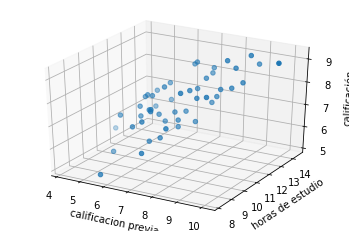

In [ ]:
# se obtienen los atributos de entrada y se agrega una dimensión
x1_trn = np.array(df.iloc[:,0], dtype='float32')[..., np.newaxis]
x2_trn = np.array(df.iloc[:,1], dtype='float32')[..., np.newaxis]
# se obtiene la salda
y_trn = np.array(df.iloc[:,-1], dtype='float32')[..., np.newaxis]
# graficamos
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(x1_trn, x2_trn, y_trn, 'green')

#plt.plot(x_trn, y_trn, '.', color='m', markersize=8)
ax.set_xlabel('calificacion previa')
ax.set_ylabel('horas de estudio')
ax.set_zlabel('calificación')
plt.show()

In [ ]:
x_trn = np.array(df.iloc[:,:2], dtype="float32")
y_trn = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]

x_trn = torch.tensor(x_trn)
y_trn = torch.tensor(y_trn)

print(x_trn.shape)
print(y_trn.shape)

torch.Size([50, 2])
torch.Size([50, 1])


### 2.1 Conjunto de datos

Para hacer lotes podemos usar las clase [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset).

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/29227f0ad9d952a2239a592a80a7990a085f43d7/figs/califs_tuberia.svg" width="1050"/>

In [ ]:
ds = TensorDataset(x_trn, y_trn)
ds[0]

(tensor([5.6000, 8.2000]), tensor([5.1000]))

### 2.2 Cargador de datos


Para ver el funcionamiento de la tubería de datos imprimimos la forma de cada lote y su primer elemento.

In [ ]:
def build_dl(batch_size=16, shuffle=True):
    global batch_size_global # siempre se usa el batch size definido globalmente
    return DataLoader(ds, batch_size=batch_size_global, shuffle=True)

# creamos un DataLoader
dl = build_dl()

x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32


In [ ]:
len(ds)

50

## 3 Ciclo de entrenamiento

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/supervisado.svg" width="700"/>

In [ ]:
# optimizador
def train(model, dl, epochs=5):
    global num_epochs
    global learning_rate

    opt = optim.SGD(model.parameters(), lr=learning_rate) #lr=1e-3)

    # historial de pérdida
    loss_hist = []

    # ciclo de entrenamiento
    for epoch in range(num_epochs):

        # historial
        loss_hist = []
        
        # entrenamiento de una época
        for x, y_true in dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos de pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # vaciamos los gradientes
            opt.zero_grad()
            # retropropagamos
            loss.backward()
            # actulizamos parámetros
            opt.step()

            # guardamos historial de pérdida
            loss_hist.append(loss.item() * 100)
            
        # imprimimos la pérdida de la época
        loss = np.mean(loss_hist)
        print(f'E{epoch:02} loss=[{loss:6.2f}]')

        
def train_model(build_model, epochs=5):
    set_seed()
    dl = build_dl()
    model = build_model()
    train(model, dl, epochs)

## 4 Definición de la arquitectura

Para implementar arquitecturas, PyTorch define dos clases fundamentales.

* `nn.Module` define una red neuronal que internamente puede tener otras redes neuronales anidadas (o capas). Tres metodos importantes son:
  * `__init__(self, args)` es el inicilizador que define al objeto,
  * `fordward(x)` realizar predicción (hacia adelante),
  * `parameters(x)` regresa una lista de los parámetros (`nn.Parameter`) de la red y redes anidadas.


* `nn.Parameter` envuelve un tensor solo para marcarlo como parámetro y que sea regresado por `nn.Module.parameters(x)`.

### 4.1 Alto nivel 

En esta API basta con apilar las capas (del paquete [`torch.nn`](https://pytorch.org/docs/stable/nn.html)) usando la clase [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential).

In [ ]:
def build_high():
    model = nn.Sequential(
        nn.Linear(2, 2),
        nn.ReLU(),
        nn.Linear(2, 1),
    )
    return model

build_high()

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

### 4.2 Medio nivel 

En esta API heredamos de [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module), creamos las capas en el inicializador e implementamos la inferencia en el método `fordward`. 

In [ ]:
#se define la clase RegLin que hereda de torch.nn.Module
class LinRegMed(nn.Module):

    #se define el inicializador
    def __init__(self):
        # se llama al inicializador de la clase padre
        super().__init__()
        # importante: se definen las capas como atributos de la clase
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

    # método para inferencia
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def build_med():
    return LinRegMed()

build_med()

LinRegMed(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)

## 5 Entrenando modelos

In [ ]:
train_model(build_high)

E00 loss=[5240.13]
E01 loss=[2730.91]
E02 loss=[622.67]
E03 loss=[ 47.03]
E04 loss=[ 16.73]


In [ ]:
train_model(build_med)

E00 loss=[5240.13]
E01 loss=[2730.91]
E02 loss=[622.67]
E03 loss=[ 47.03]
E04 loss=[ 16.73]


## 6 Prueba de predicción

A continuación se evalúan ambos modelos en un solo punto de datos, donde $x_1$ = 3.0 y $x_2$ = 12.0. Extrañamente parece que aquí ocurre un error que no logré solventar: en primera las predicciones del modelo de alto y medio nivel no coinciden, lo cual es incoherente pues se supone que representan el mismo modelo. Más aún, si se vuelven a evaluar los modelos las predicciones son muy diferentes cada vez, lo que es muy confuso pues se supone que el comportamiento de los modelos es determinista. Usar las funciones eval() y torch.no_grad() no corrige el error.

In [ ]:
test_data_point =torch.tensor([3.0,12.0], dtype=torch.float32)  # corresponde a un alumno que obtuvo 3 de calificación previa y estudio 12 horas

# Obtenemos los modelos a partir de sus funciones
high = build_high()
med = build_med()
# Activamos el modo "eval" en los modelos
high.eval()
med.eval()
# obtenemos la predicción de cada uno
with torch.no_grad():
  y1 = high(test_data_point)
  y2 = med(test_data_point)
  print(y1, y2)


tensor([0.1062]) tensor([-0.5299])


## 7 Pruebas de distintos hiperparámetros

Para evaluar el desempeño de la red bajo diferentes condiciones de hiperparámetros, se probaron distintas versiones del modelo variando solo uno de los parámetros a la vez, para ver más claramente su efecto. 

Para evitar hacer demasiado largo el notebook aquí solo se reportan los resultados de cada prueba, para ejecutar cada una solo se tiene que modificar las variables de la sección 1.2 y ejecutar de nuevo la sección 5.

### 7.1 Tamaño de lote

Para éstas pruebas se fijó el número de épocas en 5 y la tasa de aprendizaje en 1e-3. Diremos que *bs* es el tamaño de lote o batch size.

Me parecieron interesantes los resultados. El desempeño de la red respecto al valor de la pérdida fue el mejor usando *bs* = 16. Los valores cercanos -- 32, 8, y 4 -- no tuvieron un desempeño tan distinto, pero no alcanzaron la mejor pérdida. También noté que los tamaños de lote pequeños tardaban mucho más tiempo en ejecutarse, esto se debe a que al finalizar cada lote se debe ejecutar la retropropagación que es la parte más costosa en tiempo.
Pero el desempeño empeora muchísimo con mayores tamaños de lote -- tan solo con *bs* = 64 observamos que la pérdida disminuye a una velocidad mucho menor, y 10 épocas no son remotamente suficientes para encontrar un valor bueno.

La optimalidad de distintos tamaños de lote ha sido estudiada en la literatura (por ejemplo https://arxiv.org/abs/1609.04836). En resumen, parece que los modelos con lotes muy grandes resultan en minimizadores "afilados" (*sharp*) de las funciones de prueba y entrenamiento, lo que causa que sean malos generalizando. Las gradientes con lotes pequeños oscilan mucho más, lo cual podría considerarse malo porque es ruidoso, pero éste mismo ruido frecuentemente ayuda a escapar mínimos locales, haciendo más eficiente el entrenamiento. Asimismo, hay un efecto de "diminishing returns" relativo al tamaño de lote, ya que para m ejemplos se requieren O(m) computaciones pero la incertidumbre en la gradiente se reduce por un factor de O(sqrt(m)) -- es decir conforme incrementa m el beneficio que agrega cada dato nuevo es cada vez menor. 

A continuación se incluye una tabla comparativa del valor de pérdida durante las primeras 5 épocas para los distintos tamaño de lote probados: <br><br>

<table>
<tr>
<th>Tamaño de lote:</th>
<th>bs = 64</th>
<th>bs = 32</th>
<th>bs = 16</th>
<th>bs = 8</th>
<th>bs = 4</th>
</tr>
<tr>
<td>Perdida época 1:</td>
<td>5581.98</td>
<td>5309.43</td>
<td>5240.13</td>
<td>4298.79</td>
<td>2656.51</td>
</tr>
<tr>
<td>Perdida época 2:</td>
<td>5165.13</td>
<td>4590.27</td>
<td>2730.91</td>
<td>616.59</td>
<td>22.31</td>
</tr>
<tr>
<td>Perdida época 3:</td>
<td>4762.71</td>
<td>3527.72</td>
<td>622.67</td>
<td>20.56</td>
<td>19.18</td>
</tr>
<tr>
<td>Perdida época 4:</td>
<td>4323.59</td>
<td>2235.18</td>
<td>47.03</td>
<td>18.67</td>
<td>20.17</td>
</tr>
<tr>
<td>Perdida época 5:</td>
<td>3816.91</td>
<td>1053.87</td>
<td>16.73</td>
<td>19.02</td>
<td>20.66</td>
</tr>

</table>

### 7.2 Número de épocas

Para éstas pruebas se dejó fijo el tamaño de lote = 16 y tasa de aprendizaje = 1e-3, y se incrementó el número de épocas desde 5 hasta 100.

Inicialmente parece que el efecto de incrementar el número de épocas es que el valor de la pérdida continua "mejorando", decrementando aunque cada vez menos. Sin embargo eventualmente ocurre que las épocas subsecuentes ya no pueden mejorar más allá de cierto punto, y la pérdida empieza a oscilar sin llegar a valer menos que 15 -- esto ocurre tan pronto como la época número 7. 

Me parece que el motivo de que se estanque la pérdida es que simplemente hay un punto en que el modelo ya no hay más que pueda aprender de los datos, y posteriores iteraciones solo empeoran el modelo ya que empieza a ocurrir un **sobreajuste** -- aunque el modelo continua optimizándose para predecir los datos, se especializa demasiado en aprender ese conjunto particular de datos y pierde **generalidad**.

A continuación se muestra como evoluciona la pérdida luego de ejecutar 50 épocas en el modelo de alto nivel (cabe mencionar que tanto el de alto como medio nivel tuvieron exactamente el mismo comportamiento):    <br><br>
E00 loss=[5240.13]  
E01 loss=[2730.91]  
E02 loss=[622.67]  
E03 loss=[ 47.03]  
E04 loss=[ 16.73]  
E05 loss=[ 16.66]  
E06 loss=[ 15.56]  
E07 loss=[ 21.74]  
E08 loss=[ 16.46]  
E09 loss=[ 15.69]  
E10 loss=[ 16.06]  
E11 loss=[ 18.25]  
E12 loss=[ 16.12]  
E13 loss=[ 20.85]  
E14 loss=[ 21.16]  
E15 loss=[ 19.91]  
E16 loss=[ 27.50]  
E17 loss=[ 18.81]  
E18 loss=[ 16.63]  
E19 loss=[ 21.93]  
E20 loss=[ 23.46]  
E21 loss=[ 23.87]  
E22 loss=[ 24.58]  
E23 loss=[ 20.72]  
E24 loss=[ 30.29]  
E25 loss=[ 18.66]  
E26 loss=[ 15.93]  
E27 loss=[ 18.93]  
E28 loss=[ 19.14]  
E29 loss=[ 19.17]  
E30 loss=[ 15.16]  
E31 loss=[ 25.20]  
E32 loss=[ 29.54]  
E33 loss=[ 18.12]  
E34 loss=[ 19.18]  
E35 loss=[ 18.93]  
E36 loss=[ 18.15]  
E37 loss=[ 16.22]  
E38 loss=[ 21.16]  
E39 loss=[ 19.85]  
E40 loss=[ 20.32]  
E41 loss=[ 19.28]  
E42 loss=[ 21.27]  
E43 loss=[ 27.51]  
E44 loss=[ 16.16]  
E45 loss=[ 15.93]  
E46 loss=[ 20.81]  
E47 loss=[ 16.40]  
E48 loss=[ 15.84]  
E49 loss=[ 23.39]  
E50 loss=[ 15.53]   


### 7.3 Tasa de aprendizaje

Para éstos experimentos se dejaron fijos el número de épocas en 10 y tamaño de lote en 16. Podemos observar que la tasa de aprendizaje óptima está alrededor de lr=1e-3. Si la hacemos más pequeña por un factor de 10 (lr=1e-4) entonces el entrenamiento se vuelve exponencialmente más lento, y en 10 épocas la pérdida no logra ni alcanzar el valor que logró la red con lr=1e-3 en solo 2 épocas. Naturalmente este efecto se vuelve mas pronunciado con valores aún menores, y con una tasa lr=1e-5 la pérdida de hecho empieza a empeorar -- me parece que el tamaño de paso es tan pequeño que la red no está "aprendiendo" básicamente nada.

Asimismo valores mayores de la tasa como lr=1e-1 resultan ineficientes, pues la mejora en la pérdida ocurre con menor rapidez. Sin embargo al menos siempre mejora la pérdida, lo cual indica que con suficientes épocas probablemente logren una aproximación no tan mala. También es sabido que si la tasa de aprendizaje es demasiado grande el comportamiento de Descenso de Gradiente es caótico, sin embargo en éstas pruebas no probamos valores tan grandes como para ver ese efecto.

A continuación se puede como van cambiando los valores de pérdida en cada época, para cada uno de los valores de lr ejecutados:
  
lr = 1  
E00 loss=[5428.77]  
E01 loss=[2293.66]  
E02 loss=[2534.34]  
E03 loss=[2521.76]  
E04 loss=[2141.18]  
E05 loss=[1966.22]  
E06 loss=[2292.30]  
E07 loss=[2443.64]  
E08 loss=[863.84]  
E09 loss=[138.93]  
  
lr = 1e-1  
E00 loss=[1112029362.29]  
E01 loss=[62910398.44]  
E02 loss=[10554118.16]  
E03 loss=[1770969.45]  
E04 loss=[297335.57]  
E05 loss=[49914.00]  
E06 loss=[8440.65]  
E07 loss=[1628.83]  
E08 loss=[321.71]  
E09 loss=[123.77]  
  
lr = 1e-2  
E00 loss=[5653.80]  
E01 loss=[4808.92]  
E02 loss=[4118.94]  
E03 loss=[3486.48]  
E04 loss=[2991.64]  
E05 loss=[2540.47]  
E06 loss=[2169.41]   
E07 loss=[2058.08]  
E08 loss=[1730.82]  
E09 loss=[1516.86]  
  
lr = 1e-3  
E00 loss=[5240.13]  
E01 loss=[2730.91]  
E02 loss=[622.67]  
E03 loss=[ 47.03]  
E04 loss=[ 16.73]  
E05 loss=[ 16.66]  
E06 loss=[ 15.56]  
E07 loss=[ 21.74]  
E08 loss=[ 16.46]  
E09 loss=[ 15.69]  
  
lr = 1e-4  
E00 loss=[5864.29]  
E01 loss=[5299.64]  
E02 loss=[5152.71]  
E03 loss=[4956.94]  
E04 loss=[4803.97]  
E05 loss=[4616.27]  
E06 loss=[4418.95]  
E07 loss=[4487.38]  
E08 loss=[4217.44]  
E09 loss=[4011.51]  
   
lr = 1e-5  
E00 loss=[5928.01]  
E01 loss=[5512.64]  
E02 loss=[5510.84]  
E03 loss=[5461.36]  
E04 loss=[5464.80]  
E05 loss=[5427.28]  
E06 loss=[5390.24]  
E07 loss=[5717.70]  
E08 loss=[5649.67]  
E09 loss=[5696.67]  

